In [1]:
import os
import numpy as np
import torch

import scipy.io.wavfile
import cupy as cp
import cusignal

from IPython.display import Audio

In [2]:
class data_from_dir(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_dir, resample=False):
        'Initialization'
        self.resample = resample
        self.file_dir = file_dir
        self.file_filenames = [ x for x in os.listdir(file_dir) ]
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_filenames)

    def __getitem__(self, index, resample=False):
        'Load one sample of data'
        # Select sample
        sr, wave = scipy.io.wavfile.read(os.path.join(self.file_dir, self.file_filenames[index]))
        if self.resample:
            # Let's resample and scale:
            target_length = 5 # seconds
            target_sr = 48000 # sampling rate, samples per second
            wave_gpu = cp.asarray(wave)
            resampled_wave_gpu = cusignal.resample(wave_gpu, target_sr*target_length)
            resampled_wave = cp.asnumpy(resampled_wave_gpu).astype(int)
            scaled_wave = np.int16(resampled_wave/np.max(np.abs(resampled_wave)) * 32767)
            return scaled_wave.reshape(1, -1) # each element in array is one-dimensional, so need to reshape as 1-dimensional array
        else:
            return wave.reshape(1, -1)
            

In [3]:
%%time
#dataset = data_from_dir("../data/dataset/resampled", resample=False) # load already prepared and resampled files
dataset = data_from_dir("../data/dataset/small", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(dataset))

# # check all files to be consistent before pass to neural network
# for index, wave in enumerate(dataset):
#     if len(wave[0]) != 240000:
#         print("Size error:     ", dataset.file_filenames[index])
#         print("Current length: ", len(dataset[index]))
#         break
# if index+1 == len(dataset):
#     print("All files consistent and have same length 240k amplitudes each")
# print()
# print()

# wave

Dataset size:  2000
CPU times: user 2.28 ms, sys: 348 µs, total: 2.62 ms
Wall time: 1.93 ms


In [4]:
%%time
# check one file in dataset to be sure everything is good:
file_number=7
wave = dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)


Type:               <class 'numpy.ndarray'>
Data:               [ -8647 -10090  -9741 ...  -2161  -2124  -3448]
Sampling rate:      48000
Samples:            240000
Audio length:       5.0 seconds
Lowest amplitude:   -27862
Highest amplitude:  32767

Scaled from dataset:
CPU times: user 107 ms, sys: 193 µs, total: 107 ms
Wall time: 111 ms


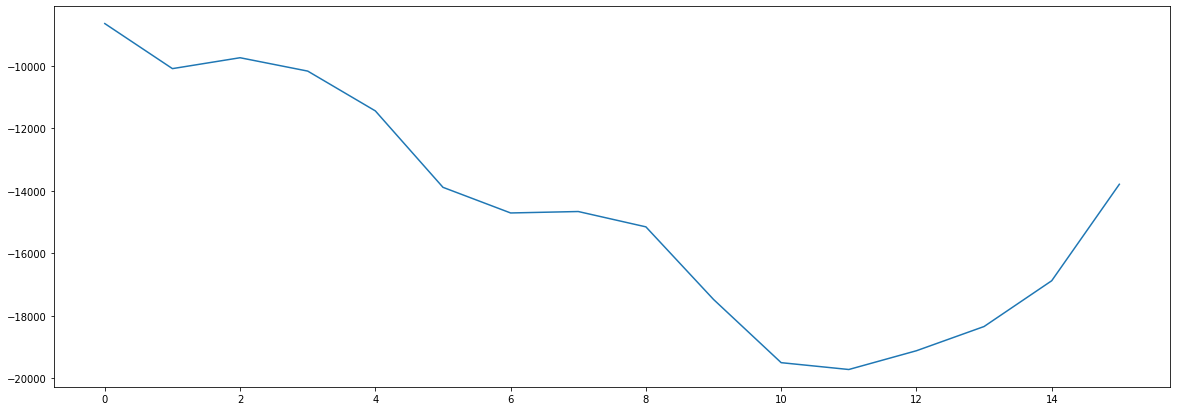

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,7))
plt.plot(dataset[file_number][0][0:16]) # plotting by columns
plt.show()

In [5]:
%%time
print("Original source:")
sr, wave = scipy.io.wavfile.read(os.path.join("../data/sliced", dataset.file_filenames[file_number]))
Audio(wave, rate=sr)

Original source:
CPU times: user 356 µs, sys: 3.51 ms, total: 3.86 ms
Wall time: 10.2 ms


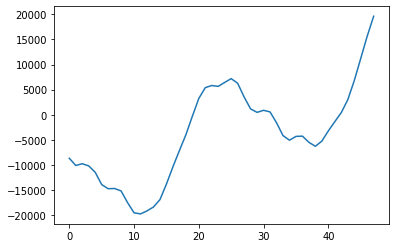

In [6]:
%%time
# now split whole dataset to train and test subsets
# get 10% for tests

train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("Train dataset size: ", len(train_dataset))
print("Test dataset size:  ", len(test_dataset))
print()

Train dataset size:  1000
Test dataset size:   1000

CPU times: user 1.63 ms, sys: 283 µs, total: 1.91 ms
Wall time: 6.81 ms


In [7]:
%%time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True) #, num_workers=4) # num_workers have an issue, not working
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) #, num_workers=4)

CPU times: user 70 µs, sys: 12 µs, total: 82 µs
Wall time: 85.6 µs


In [8]:
### library for plot online update
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

In [9]:
# describe model architecture

# class Recurrent(nn.Module):
#     def __init__(self, rnn_size):
#         super(Recurrent, self).__init__()
#         self.gru = nn.GRU(input_size=3, hidden_size=rnn_size)
#         self.fc = nn.Linear(rnn_size, 2)

#     def forward(self, x):
#         x = x.permute(2, 0, 1)
#         output, hidden = self.gru(x)
#         return self.fc(hidden.squeeze(0))

class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # 240k - 9600 - 600 - 50 - 5 - 1
        # encoder
        # 240k with 1-dimension using window=48 goes to 4-dimension and will maxpool feature map to 9600 outputs
        self.encoder1 = torch.nn.Sequential(torch.nn.Conv1d(1, 32, kernel_size=48, stride=1, padding=24, dilation=1), 
                                    torch.nn.ReLU(), 
                                    torch.nn.MaxPool1d(kernel_size=25, stride=25))
        # feature map = 600
        self.encoder2 = torch.nn.Sequential(torch.nn.Conv1d(32, 64, kernel_size=48, stride=1, padding=24, dilation=1), 
                                    torch.nn.ReLU(), 
                                    torch.nn.MaxPool1d(kernel_size=16, stride=16))
        # feature map = 50
        self.encoder3 = torch.nn.Sequential(torch.nn.Conv1d(64, 128, kernel_size=12, stride=1, padding=6, dilation=1), 
                                    torch.nn.ReLU(), 
                                    torch.nn.MaxPool1d(kernel_size=12, stride=12))
        # feature map = 5
        self.encoder4 = torch.nn.Sequential(torch.nn.Conv1d(128, 256, kernel_size=4, stride=1, padding=2, dilation=1), 
                                    torch.nn.ReLU(), 
                                    torch.nn.MaxPool1d(kernel_size=10, stride=10))
 
        # decoder 
        # a kernel of 5 and a stride of 5 will increase the spatial dims by 5 - like "un-maxpooling"
        self.decoder1 = torch.nn.ConvTranspose1d(256, 128, kernel_size=10, stride=10)
        self.decoder2 = torch.nn.ConvTranspose1d(128, 64, kernel_size=12, stride=12)
        self.decoder3 = torch.nn.ConvTranspose1d(64, 32, kernel_size=16, stride=16)
        self.decoder4 = torch.nn.ConvTranspose1d(32, 1, kernel_size=25, stride=25)
 

    def forward(self, x):
        #print("input:", len(x[0][0]))
        x = self.encoder1(x)
        #print("encoder 1:", len(x[0]))
        x = self.encoder2(x)
        #print("encoder 2:", len(x[0]))
        x = self.encoder3(x)
        #print("encoder 3:", len(x[0]))
        x = self.encoder4(x)
        #print("encoder 4:", len(x[0]))
        
        x = torch.nn.functional.relu(self.decoder1(x))
        #print("decoder 1:", len(x[0]))
        x = torch.nn.functional.relu(self.decoder2(x))
        #print("decoder 2:", len(x[0]))
        x = torch.nn.functional.relu(self.decoder3(x))
        #print("decoder 3:", len(x[0]))
        x = torch.nn.functional.tanh(self.decoder4(x))
        #print("output 4:", len(x[0][0]))
        x = x.view(-1, 5*10*12*16*25) # 240000
        # output layer (with sigmoid for scaling from 0 to 1)
        #x = torch.nn.functional.sigmoid(x)
        return x

In [10]:
# train on cuda if available
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# train with (test on each epoch)
def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    softmaxed = torch.nn.Softmax()
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            # running_corrects = 0 # no correct answers for autoencoders

            for idx, inputs in enumerate(dataloaders[phase]):
                inputs = inputs.to(device, dtype=torch.float)
                # labels = inputs.to(device, dtype=torch.long)
                # labels = labels.to(device)
                #outputs = model(inputs / 32767.0).float()
                outputs = model(inputs)
                #break
                
                #Y = softmaxed(outputs)
                #X = softmaxed((inputs / 32767.0))
                #X = softmaxed(inputs)
                #loss = criterion(Y, X)
                loss = criterion(outputs, inputs)
#                print("loss: ", loss)
                # loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # _, preds = torch.max(outputs, 1) # no correct answers for autoencoders
                running_loss += loss.detach() * inputs.size(0)
                # running_corrects += torch.sum(preds == inputs.data) # no correct answers for autoencoders
                # running_corrects += torch.sum(preds == labels.data) # no correct answers for autoencoders
                ###print(f"\r[{idx}/{len(source_files)}] {round(100.0 * idx/len(source_files), 2)}%: {j}", end = "")


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'test':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            print("logs: ", logs)
            # logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

In [11]:
# model = Recurrent(8)
torch.cuda.empty_cache()
model = ConvAutoencoder()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

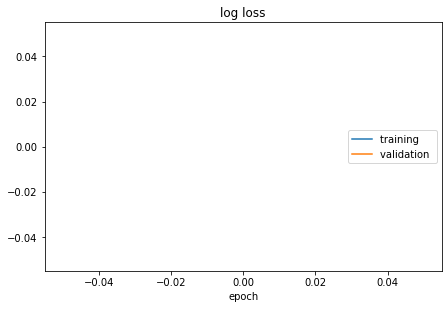

log loss
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)


In [12]:
train_model(model, criterion, optimizer, num_epochs=5)

In [13]:
a=torch.nn.BCELoss()
softmaxed = torch.nn.Softmax()
x = softmaxed(torch.Tensor([3, 0.9]))
print(x)
y = softmaxed(torch.Tensor([-3, -0.9]))
print(y)
print(a(x,y))

tensor([0.8909, 0.1091])
tensor([0.1091, 0.8909])
tensor(1.9864)


/opt/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
